In [1]:
import numpy as np 
import os 
import tensorflow as tf
import sklearn 
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#clustering
from scipy.cluster.hierarchy import complete,single, fcluster,dendrogram
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import pdist
from sklearn.metrics import pairwise_distances
import datetime
import seaborn as sns


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
indices_agg=[]
for i in range(1,6):
  indices_agg.append(np.load(f"/content/drive/MyDrive/MasterCD/hackatlon/datos/datos_cluster_dtw/1/timeseries_from_0_len400_index_{i}.npy"))

datos=pd.read_csv("/content/drive/MyDrive/MasterCD/hackatlon/datos/consumo_aggbyday_filledzeros_samelength.csv" ,sep=",")
lectura=datos.iloc[:,1:].fillna(0,inplace=False).to_numpy().T

In [ ]:
print(lectura.shape,datos.shape)

(2747, 365) (365, 2748)


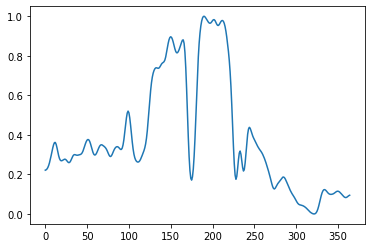

In [ ]:
#vamos a suavizar todo y a escalarlo
data_filtered=ndimage.gaussian_filter(lectura,[0,3],0)
scaler=MinMaxScaler()
data_pre=scaler.fit_transform(data_filtered.T).T
plt.plot(data_pre[32])

## Clustering jerarquico sencillito

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:360: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='complete', metric='euclidean')


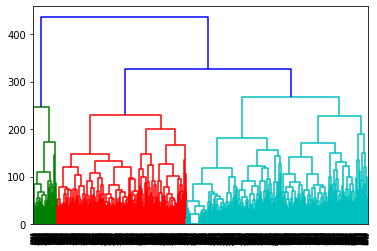

In [ ]:
d=pairwise_distances(data_pre)
a=complete(d)
dendrogram(a);

In [ ]:
ind=fcluster(a,4,"maxclust")

In [ ]:
#sacamos los subgrupos
datos_g=[]
for i in range(1,5):
  datos_g.append(data_pre[ind==i])
  print(datos_g[i-1].shape)

(196, 365)
(1062, 365)
(782, 365)
(707, 365)


In [ ]:
#vamos a entrenar en modelo con el grupo mas grande primero
#preparamos los datos
x_train,x_test= train_test_split(datos_g[1],test_size=0.2)
x_train.shape

(849, 365)

In [ ]:
#funcion para hacer enventanados
def window(data_big,size_input,size_output=None):
  if size_output is not None:
    #esto para implementar que se devuelvan ventanas mas grandes
    features=[]
    labels=[]
    for i in range(0,data_big.shape[0]):
      data=data_big[i]
      for j in range(data_big.shape[1] - size_input -size_output):
        features.append(data[j:(j+size_input)])
        labels.append(data[(j+size_input):(j+size_input+size_output)])
  else:
    features=[]
    labels=[]
    for i in range(0,data_big.shape[0]):
      data=data_big[i]
      for j in range(data_big.shape[1] - size_input -1):
        features.append(data[j:(j+size_input)])
        labels.append(data[j+size_input+1])
  return np.array(features),np.array(labels)    

(365328, 20) (365328,)


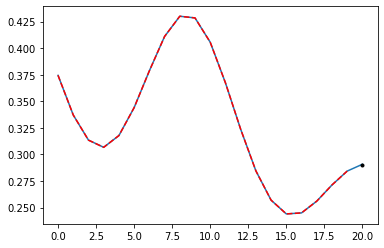

In [ ]:
feat,labs=window(datos_g[1],20)
print(feat.shape,labs.shape)
plt.plot(range(21),datos_g[1][0][11:32])
plt.plot(range(20),feat[11],"--r")
plt.plot(20,labs[11],".k")


In [ ]:
x_train,x_test,y_train,y_test= train_test_split(feat,labs,test_size=0.2)


## Modelo LSTM

Aqui podemos entrenar con o sin ventanas, en principio lo hacemos sin.


In [ ]:
input=tf.keras.layers.Input(shape=[20,1])
x=tf.keras.layers.LSTM(30,return_sequences=True)(input)
x=tf.keras.layers.LSTM(60,return_sequences=False)(x)
x=tf.keras.layers.Dense(50,activation="relu")(x)
x=tf.keras.layers.Dense(1,activation="sigmoid")(x)

model=tf.keras.Model(input,x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 20, 30)            3840      
                                                                 
 lstm_1 (LSTM)               (None, 60)                21840     
                                                                 
 dense (Dense)               (None, 50)                3050      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 28,781
Trainable params: 28,781
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam",loss="mse")
hist=model.fit(x_train,y_train,epochs=20,batch_size=128,validation_split=0.2)

Epoch 1/20
1827/1827 [==============================] - 37s 16ms/step - loss: 0.0032 - val_loss: 3.6119e-04
Epoch 2/20
1827/1827 [==============================] - 29s 16ms/step - loss: 2.3961e-04 - val_loss: 1.8134e-04
Epoch 3/20
1827/1827 [==============================] - 29s 16ms/step - loss: 1.1922e-04 - val_loss: 8.4001e-05
Epoch 4/20
1827/1827 [==============================] - 28s 16ms/step - loss: 6.6858e-05 - val_loss: 3.7822e-05
Epoch 5/20
1827/1827 [==============================] - 29s 16ms/step - loss: 4.4358e-05 - val_loss: 6.4450e-05
Epoch 6/20
1827/1827 [==============================] - 28s 15ms/step - loss: 3.1446e-05 - val_loss: 2.4674e-05
Epoch 7/20
1827/1827 [==============================] - 28s 15ms/step - loss: 2.5826e-05 - val_loss: 1.7646e-05
Epoch 8/20
1827/1827 [==============================] - 28s 15ms/step - loss: 2.1956e-05 - val_loss: 2.7960e-05
Epoch 9/20
1827/1827 [==============================] - 28s 15ms/step - loss: 1.8069e-05 - val_loss: 1.5865e

In [ ]:
x_train.shape

(292262, 20)

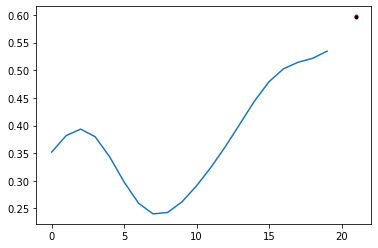

In [ ]:
n=123
y_pred=model.predict(x_test[n][np.newaxis,... ])
plt.plot(range(20),x_test[n])
plt.plot(21,y_test[n],".r")
plt.plot(21,y_pred,".k")


In [ ]:
#vamos a crear una funcion que le pases una serie temporar y te prediga los n ultimos
#recurrentemente con la ultima prediccion del modelo
def pred_model(model,ts,n_preds):
  input=model.input_shape[1]
  #init_window=ts.shape[0]-n_preds-input
  seen_data=ts[:(ts.shape[0]-n_preds)]
  pred=[]
  for i in range(n_preds):
    #cogemos los ultimos y vamos avanzando
    input_pred=seen_data[-input:]#las ultimas inputs
    out_pred=model.predict(input_pred[np.newaxis,...])
    pred.append(out_pred[0])
    seen_data=np.append(seen_data,out_pred)
  return np.array(pred)


In [ ]:
#predecimos solo el siguiente valor 

def pred_model2(model,ts):
  input_size=model.input_shape[1]
  leng=ts.shape[0]
  preds=[]
  for i in range(input_size,leng):
    preds.append(model.predict(ts[(i-input_size):i][np.newaxis,...])[0][0])
  return np.array(preds)

In [ ]:
m=32
a=pred_model(model,datos_g[1][m],7)
plt.figure()
plt.subplot(1,2,1)
plt.plot(datos_g[1][m])
plt.plot(range(datos_g[1][m].shape[0]-7,datos_g[1][m].shape[0]),a,"--")
plt.subplot(1,2,2)
plt.plot(datos_g[1][m][-7:])
plt.plot(a,"--")


NameError: ignored

In [ ]:
a=pred_model2(model,datos_g[1][1])
a.shape


(345,)

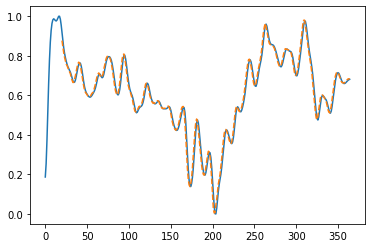

In [ ]:
plt.plot(datos_g[1][1])
plt.plot(range(20,datos_g[1][1].shape[0]),a,"--")

### Output mas largo

In [ ]:
feat,labs=window(datos_g[1],20,7)
print(labs.shape,feat.shape)
x_train,x_test,y_train,y_test= train_test_split(feat,labs,test_size=0.2)


(358956, 7) (358956, 20)


In [ ]:
input=tf.keras.layers.Input(shape=[20,1])
x=tf.keras.layers.LSTM(30,return_sequences=True)(input)
x=tf.keras.layers.LSTM(60,return_sequences=False)(x)
x=tf.keras.layers.Dense(50,activation="relu",kernel_regularizer="l2")(x)
x=tf.keras.layers.Dense(7,activation="sigmoid",kernel_regularizer="l2")(x)

model=tf.keras.Model(input,x)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 lstm_8 (LSTM)               (None, 20, 30)            3840      
                                                                 
 lstm_9 (LSTM)               (None, 60)                21840     
                                                                 
 dense_8 (Dense)             (None, 50)                3050      
                                                                 
 dense_9 (Dense)             (None, 7)                 357       
                                                                 
Total params: 29,087
Trainable params: 29,087
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam",loss="mse")
hist=model.fit(x_train,y_train,epochs=20,batch_size=128,validation_split=0.2)

Epoch 1/20
1795/1795 [==============================] - 34s 16ms/step - loss: 0.0585 - val_loss: 0.0246
Epoch 2/20
1795/1795 [==============================] - 27s 15ms/step - loss: 0.0226 - val_loss: 0.0211
Epoch 3/20
1795/1795 [==============================] - 28s 15ms/step - loss: 0.0204 - val_loss: 0.0197
Epoch 4/20
1795/1795 [==============================] - 28s 15ms/step - loss: 0.0194 - val_loss: 0.0190
Epoch 5/20
1795/1795 [==============================] - 28s 16ms/step - loss: 0.0188 - val_loss: 0.0186
Epoch 6/20
1795/1795 [==============================] - 27s 15ms/step - loss: 0.0184 - val_loss: 0.0181
Epoch 7/20
1795/1795 [==============================] - 28s 15ms/step - loss: 0.0181 - val_loss: 0.0181
Epoch 8/20
1795/1795 [==============================] - 28s 15ms/step - loss: 0.0179 - val_loss: 0.0178
Epoch 9/20
1795/1795 [==============================] - 27s 15ms/step - loss: 0.0177 - val_loss: 0.0174
Epoch 10/20
1795/1795 [==============================] - 27s 15m

In [ ]:
def pred_model2(model,ts,window):
  input_size=model.input_shape[1]
  leng=ts.shape[0]
  preds=[]
  for i in range(input_size,leng-window,window):
    preds.append(model.predict(ts[(i-input_size):i][np.newaxis,...])[0])
  return np.array(preds)

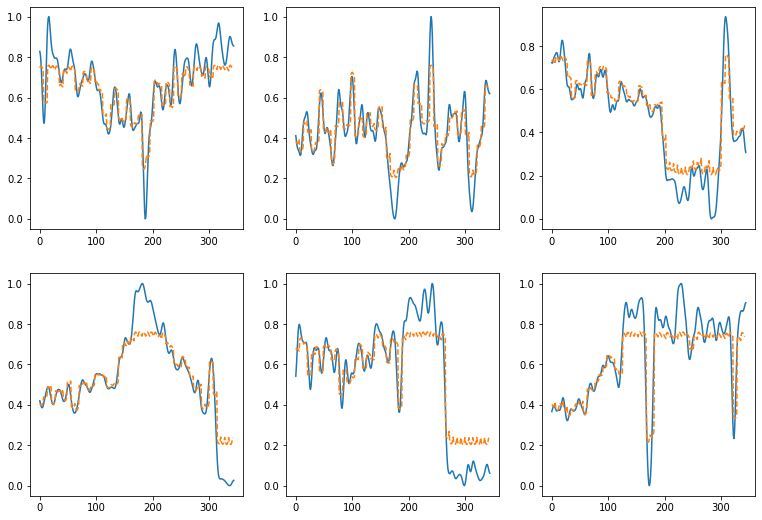

In [ ]:
plt.figure(figsize=(13,9))
for i,m in enumerate([23,56,76,43,12,65]):
  plt.subplot(2,3,i+1)
  a=pred_model2(model,datos_g[1][m],7)
  a.shape
  a=a.flatten()
  plt.plot(datos_g[1][m][20:])
  plt.plot(a,"--")

In [ ]:
#vamos a meter las series temporales de temperatura, presion y tal
extra=pd.read_csv("/content/drive/MyDrive/MasterCD/hackatlon/datos/2d5e32da-b460-4960-9f74-91c854e13c98.csv" ,sep=",")
#añadimos una columna DATETIME
dict_repl={"Enero":"01","Febrero":"02","Marzo":"03","Abril":"04","Mayo":"05",
           "Junio":"06","Julio":"7","Agosto":"08","Septiembre":"09","Octubre":"10",
           "Noviembre":"11","Diciembre":"12"}
def rep_month(mon):
  for i in dict_repl:
    return mon.replace(i,dict_repl[i])
#**Ojo porque no etamos especificando la estación**
extra.loc[:,"Mes"]=extra.loc[:,"Mes"].astype(str).apply(lambda x: rep_month(x))
extra.loc[:,"Temp."]=extra.loc[:,"Temp."].astype(str).apply(lambda x: x.replace(",",".")).astype(float)
extra.loc[:,"Pres."]=extra.loc[:,"Pres."].astype(str).apply(lambda x: x.replace(",",".")).astype(float)
extra.loc[:,"Precip."]=extra.loc[:,"Precip."].astype(str).apply(lambda x: x.replace(",",".")).astype(float)

extra.loc[:,"Fecha Hora"]=extra.loc[:,"Fecha Hora"].astype(str).apply(lambda x: x.replace(",",".")).astype(float)
extra=extra.sort_values("Fecha Hora")
extra.loc[:,"Día"]=extra.loc[:,"Día"].astype(str).apply(lambda x: x.zfill(2))
extra.loc[:,"Año"]=extra.loc[:,"Año"].astype(str)
extra["DATE"]=extra.loc[:,"Año"]+"-"+extra.loc[:,"Mes"]+"-"+extra.loc[:,"Día"]
print(extra.columns)
extra.head()


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (20,21,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['_id', 'Mes', 'Semana', 'Día', 'Hora', 'Fecha Hora', 'Año', 'Estación',
       'PM1', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'O3', 'SO2', 'CO', 'Veloc.',
       'Direc.', 'NH3', 'C7H8', 'C6H6', 'Ruido', 'C8H10', 'Temp.', 'H.Rel.',
       'Pres.', 'R.Sol.', 'Precip.', 'Veloc. Max', 'DATE'],
      dtype='object')


,_id,Mes,Semana,Día,Hora,Fecha Hora,Año,Estación,PM1,PM2.5,...,C6H6,Ruido,C8H10,Temp.,H.Rel.,Pres.,R.Sol.,Precip.,Veloc. Max,DATE
175440,175441,01,Lunes,01,0,43101.00000,2018,Pista Silla,NaN,2.0,...,"0,2",59.0,"0,2",14.2,38.0,1013.0,0.0,0.0,"13,2",2018-01-01
166680,166681,01,Lunes,01,0,43101.00000,2018,Bulevard Sud,NaN,NaN,...,NaN,NaN,NaN,14.2,38.0,1013.0,0.0,0.0,"13,2",2018-01-01
157920,157921,01,Lunes,01,0,43101.00000,2018,Avda. Francia,NaN,3.0,...,NaN,NaN,NaN,14.2,38.0,1013.0,0.0,0.0,"13,2",2018-01-01
184200,184201,01,Lunes,01,0,43101.00000,2018,Politécnico,NaN,3.0,...,NaN,NaN,NaN,14.2,38.0,1013.0,0.0,0.0,"13,2",2018-01-01
175441,175442,01,Lunes,01,"0,041666667",43101.04167,2018,Pista Silla,NaN,2.0,...,"0,6",60.0,"0,2",12.8,46.0,1014.0,0.0,0.0,"13,5",2018-01-01


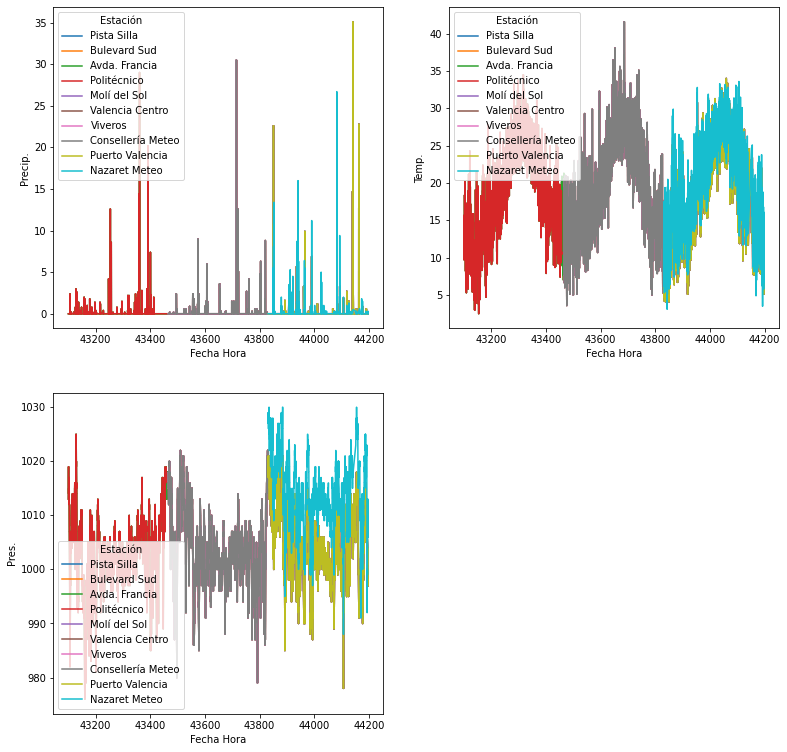

In [ ]:
plt.figure(figsize=(13,13))
plt.subplot(2,2,1)
sns.lineplot(data=extra,x="Fecha Hora",y="Precip.",hue="Estación")
plt.subplot(2,2,2)
sns.lineplot(data=extra,x="Fecha Hora",y="Temp.",hue="Estación")
plt.subplot(2,2,3)
sns.lineplot(data=extra,x="Fecha Hora",y="Pres.",hue="Estación")

Como parece que ninguna cubre temporalmente todo, vamos sin especificar, pero quitaremos a Nazaret que tiene valores muy altos.

In [ ]:
extra=extra.drop(extra.loc[extra["Estación"]=="Nazaret Meteo",:].index)

In [ ]:
datos.head()

,DATE,DELTA_ID1,DELTA_ID2,DELTA_ID3,DELTA_ID4,DELTA_ID5,DELTA_ID6,DELTA_ID7,DELTA_ID8,DELTA_ID9,...,DELTA_ID2738,DELTA_ID2739,DELTA_ID2740,DELTA_ID2741,DELTA_ID2742,DELTA_ID2743,DELTA_ID2744,DELTA_ID2745,DELTA_ID2746,DELTA_ID2747
0,2019-02-01,800,0,49200,25260,44496,8000,4500,400,10900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-02-02,4700,0,38100,24171,0,1100,3600,0,30500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-02-03,600,0,31300,26641,0,6900,42600,0,20500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-02-04,1200,0,36200,41200,0,27196,43300,700,28700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-02-05,4400,0,38000,26900,0,23092,6300,0,15000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#mezclamos ambas tablas

#hagmos la media sobre la date
aux=extra.loc[:,["Temp.","Pres.","Precip.","DATE"]].groupby(by="DATE").mean()

merged=pd.merge(datos,aux,how="left",on="DATE")
merged.head()

,DATE,DELTA_ID1,DELTA_ID2,DELTA_ID3,DELTA_ID4,DELTA_ID5,DELTA_ID6,DELTA_ID7,DELTA_ID8,DELTA_ID9,...,DELTA_ID2741,DELTA_ID2742,DELTA_ID2743,DELTA_ID2744,DELTA_ID2745,DELTA_ID2746,DELTA_ID2747,Temp.,Pres.,Precip.
0,2019-02-01,800,0,49200,25260,44496,8000,4500,400,10900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-02-02,4700,0,38100,24171,0,1100,3600,0,30500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-02-03,600,0,31300,26641,0,6900,42600,0,20500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-02-04,1200,0,36200,41200,0,27196,43300,700,28700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-02-05,4400,0,38000,26900,0,23092,6300,0,15000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
merged_plus.shape

(2750, 365)

In [ ]:
merged_plus=merged.iloc[:,1:].fillna(0,inplace=False).to_numpy().T

#normalizamos
scal=MinMaxScaler()
merged_plus_norm=scal.fit_transform(merged_plus.T)
print(merged_plus_norm.shape)
consumo,extras=merged_plus_norm[:,:-3],merged_plus_norm[:,-3:]
print(extras.shape,consumo.shape)

(365, 2750)
(365, 3) (365, 2747)


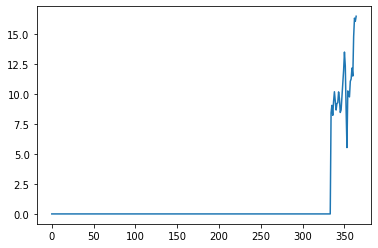

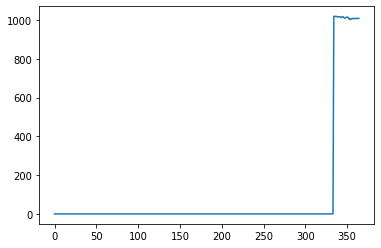

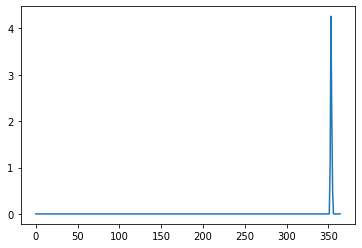

In [ ]:
plt.figure()
plt.plot(extras[0,:])
plt.figure()
plt.plot(extras[1,:])
plt.figure()
plt.plot(extras[2,:])

Ahora preparamos los datos para meterle 4 canales a la red.

In [ ]:
#esta funcion coge series como input y las secciona, dando n puntos iniciales (feature) y los m siguientes (labels)

def window(data_big,size_input,size_output=None,data_aux=None):
  if size_output is not None:
    #esto para implementar que se devuelvan ventanas mas grandes
    features=[]
    labels=[]
    #if data_aux is not None:
      #data_aux=data_aux.T

    for i in range(0,data_big.shape[0]):
      data=data_big[i]
      for j in range(data_big.shape[1] - size_input -size_output):
        if data_aux is not None:
          data_aux_slice=data_aux[j:(j+size_input),:]
          features.append(np.hstack([data[j:(j+size_input)][...,np.newaxis],data_aux_slice]))
        else:
          features.append(data[j:(j+size_input)])
        labels.append(data[(j+size_input):(j+size_input+size_output)])
  else:
    features=[]
    labels=[]
    for i in range(0,data_big.shape[0]):
      data=data_big[i]
      for j in range(data_big.shape[1] - size_input -1):
        if data_aux is not None:
          data_aux_slice=data_aux[j:(j+size_input),:]
          features.append(np.hstack([data[j:(j+size_input)][...,np.newaxis],data_aux_slice]))
        else:
          features.append(data[j:(j+size_input)])
        labels.append(data[j+size_input+1])
  return np.array(features),np.array(labels)  

In [ ]:
a,b=window(consumo,20,7,extras)

ValueError: ignored

In [ ]:
print(a.shape,b.shape)

(928486, 20, 4) (928486, 7)


In [ ]:

x_train,x_test,y_train,y_test= train_test_split(a,b,test_size=0.2)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(742788, 20, 4) (185698, 20, 4) (742788, 7) (185698, 7)


In [ ]:
input=tf.keras.layers.Input(shape=[20,4])
x=tf.keras.layers.LSTM(30,return_sequences=True)(input)
x=tf.keras.layers.LSTM(60,return_sequences=False)(x)
x=tf.keras.layers.Dense(50,activation="relu",kernel_regularizer="l2")(x)
x=tf.keras.layers.Dense(7,activation="sigmoid",kernel_regularizer="l2")(x)

model=tf.keras.Model(input,x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 4)]           0         
                                                                 
 lstm (LSTM)                 (None, 20, 30)            4200      
                                                                 
 lstm_1 (LSTM)               (None, 60)                21840     
                                                                 
 dense (Dense)               (None, 50)                3050      
                                                                 
 dense_1 (Dense)             (None, 7)                 357       
                                                                 
Total params: 29,447
Trainable params: 29,447
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam",loss="mse")
hist=model.fit(x_train,y_train,epochs=20,batch_size=128,validation_split=0.2)

Epoch 1/20
4640/4643 [============================>.] - ETA: 0s - loss: 11362900115456.0000

KeyboardInterrupt: ignored